# Предобработка датасета

В этом коллабе собраны анализ данных и обработка пропусков, выбросов и дубликатов, а также приведение столбцов к удобному формату для дальнейшей работы.

In [99]:
import os, re, glob, ast
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer

In [100]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [101]:
PATH = "dataset_final.csv"
df = pd.read_csv(PATH, low_memory=False)
df.columns = [c.strip().lower() for c in df.columns]

## Очистка датасета от пропусков

**Что именно делает наш блок очистки**

1) Приводим строки к нормальному виду

В исходном датасете часто встречаются строковые «заглушки» типа "nan", "None", пустые строки и т.д. В pandas это не считается за настоящие пропуски. Мы аккуратно заменяем всё это на реальные NaN, чтобы пропуски считались честно и дальше их было удобно обрабатывать

2) Проверяем на наличие дубликатов, так как у нас их нет, то ничего удалять не нужно

3) Подготавливаем признаки

* Даты переводим в datetime и дополнительно считаем release_year, release_month, release_dow

* Списочные поля (жанры/платформы/теги) из строк приводим к реальным спискам

* Основной жанр — если у нас определен primary_genre, то мы берем его, а если не определен - первый элемент из списка жанров, и сохраняем в поле main_genre. Это нам нужно для «локальной» импутации

* Числовые поля (цены, скидки, рейтинги, счётчики) переводим к числам: избавляемся от символов валюты, из запятых делаем точки и т.п.

4) Импутируем числовые пропуски: KNN «по жанрам», потом «по всему датасету» остатки

**Основная идея алгоритма KNN:**

Сначала мы не перемешиваем все игры, а смотрим в рамках основного жанра (main_genre)

* Для каждой игры с пропуском ищем 5 ближайших соседей по остальным числовым признакам (цена, рейтинги, длина описания, счётчики и т.д.)

* Затем пропущенное значение подставляем как среднее по найденным соседям

**Чтобы это работало устойчиво:**

* внутри каждой жанровой группы мы берём только те числовые столбцы, где в этой группе есть хотя бы одно значение (иначе KNNу нечем будет «мерить» расстояния)

* ограничиваем число соседей: k = min(5, размер_группы − 1) — то есть не просим у маленькой группы больше соседей, чем в ней есть

* присваиваем результат строго в тот же набор колонок и только тем строкам, для которых импутировали — так не возникает ошибок формы

После первого шага иногда остаются хвостовые пропуски (редкие жанры или слишком маленькие группы). Тогда мы делаем один глобальный проход KNN по всему датасету с k = 7 — это финальный доводчик, чтобы закрыть всё до конца

Итого: у нас k=5 внутри жанра и k=7 — глобально на остаток

5) Категориальные и даты — по моде

Там, где у нас текст/категории/даты, мы делаем проще и безопасней: сначала подставляем моду внутри жанра, если не получилось — глобальную моду, а в крайнем случае — Unknown. Это сохраняет локальный контекст и не навязывает случайные категории

In [102]:
# Нормализация строковых значений + подсчёт дублей и пропусков
for c in df.select_dtypes("object"):
    df[c] = df[c].astype(str).str.strip().replace(["", "none", "None", "nan", "NaN"], np.nan)

dup_before = int(df.astype(str).duplicated().sum())
print(f"Дубликаты:{dup_before}")

miss_before = int(df.isna().sum().sum())
print("Пропусков ДО:", miss_before)

###
date_col = "released" if "released" in df.columns else ("release_date" if "release_date" in df.columns else None)
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["release_year"] = df[date_col].dt.year
    df["release_month"] = df[date_col].dt.month
    df["release_dow"] = df[date_col].dt.dayofweek

# Опр основного жанра
if "primary_genre" in df.columns:
    df["main_genre"] = df["primary_genre"].fillna("Unknown")
else:
   s = df.get("genres", pd.Series("", index=df.index)).astype(str)

   df["main_genre"] = (
      s.str.replace(r"[\[\]']", "", regex=True)
      .str.split(",").str[0]
      .str.strip()
      .replace("", np.nan)
      .fillna("Unknown"))

# 5) Приведение ключевых метрик к числовому типу
num_like = ["rating","ratings_count","reviews_count","suggestions_count","added",
            "rating_5","rating_4","rating_3","rating_2","rating_1",
            "metacritic","metacritic_score","playtime",
            "platform_count","store_count","achievements_count","description_length",
            "price","final_price","initial_price","discount_percent"]
for c in num_like:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

###
def knn_impute_by_genre(df_in, k = 5):
    df_out = df_in.copy()
    num_cols = df_out.select_dtypes("number").columns.tolist()

    for genre, block in df_out.groupby("main_genre", sort=False):
        cols = [c for c in num_cols if block[c].notna().any()]
        if len(cols) == 0 or len(block) < 2:
            continue

        k_eff = min(k, len(block) - 1)
        imputer = KNNImputer(n_neighbors=k_eff)
        df_out.loc[block.index, cols] = imputer.fit_transform(block[cols])
    return df_out

df = knn_impute_by_genre(df, k=5)

###
num_cols = df.select_dtypes("number").columns
if df[num_cols].isna().sum().sum() > 0:
    df[num_cols] = KNNImputer(n_neighbors=7).fit_transform(df[num_cols])

# Заполнение категориальных и дат
obj_cols = [c for c in df.select_dtypes("object").columns if c != "main_genre"]
for c in obj_cols:
    df[c] = df.groupby("main_genre")[c].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    if df[c].isna().any():
        m = df[c].mode()
        df[c] = df[c].fillna(m.iloc[0] if not m.empty else "Unknown")

if date_col and df[date_col].isna().any():
    m = df[date_col].mode()
    df[date_col] = df[date_col].fillna(m.iloc[0] if not m.empty else "Unknown")

###
miss_after = int(df.isna().sum().sum())
print("Пропусков ПОСЛЕ:", miss_after)

Дубликаты:0
Пропусков ДО: 12918
Пропусков ПОСЛЕ: 0


### Проверим сильно ли у нас меняются перцентили и медианны по каждому разделу после обработки пропусков

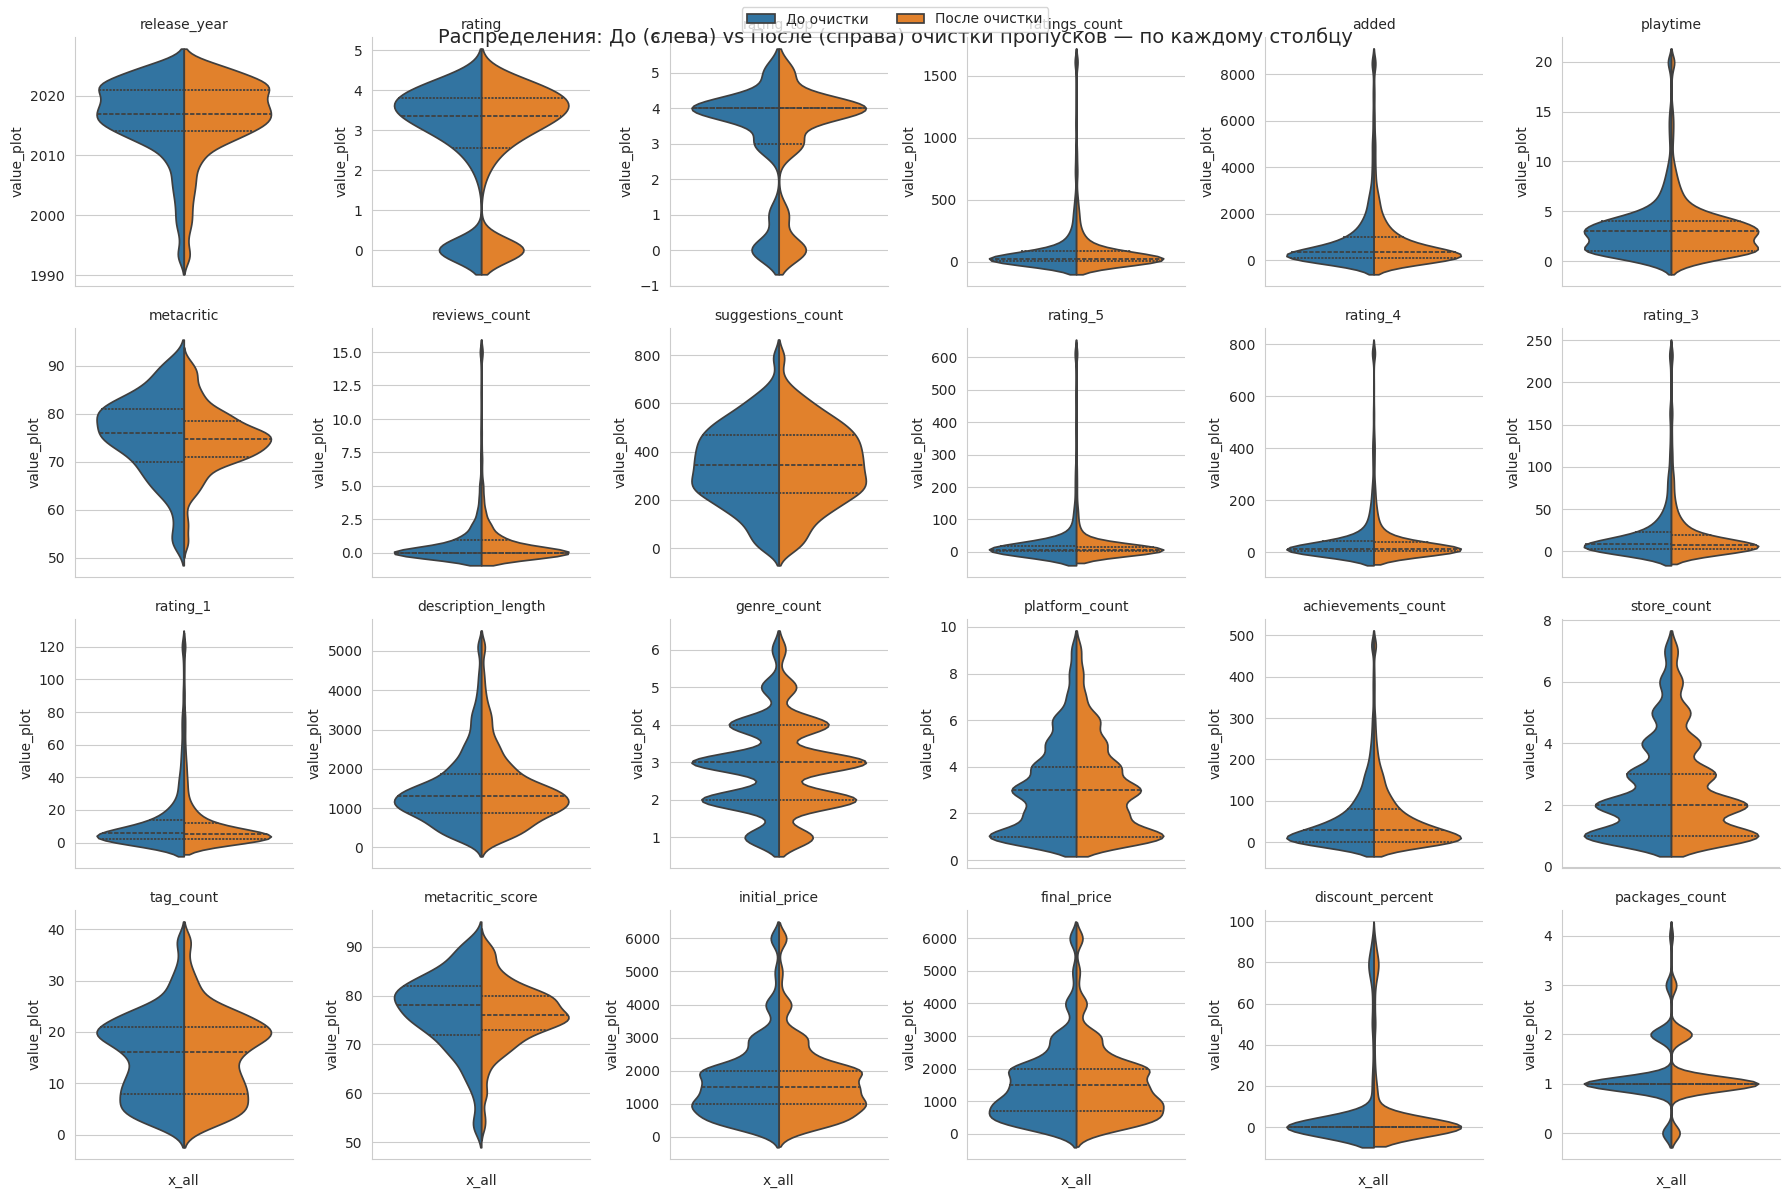

In [103]:
PATH = "dataset_final.csv"
df_before = pd.read_csv(PATH)

df_after = df.copy()

###
num_before = df_before.select_dtypes(include="number").columns
num_after  = df_after.select_dtypes(include="number").columns
cols = [c for c in num_before if c in set(num_after)]

###
def melt_for(frame, label, columns):
    d = frame[columns].replace([np.inf, -np.inf], np.nan)
    out = d.melt(var_name='column', value_name='value').dropna(subset=['value'])
    out['dataset'] = label
    return out

long_df = pd.concat([
    melt_for(df_before, "До очистки", cols),
    melt_for(df_after,  "После очистки", cols)
], ignore_index=True)

###
long_df['value_plot'] = (long_df['value'].replace([np.inf, -np.inf], np.nan).groupby(long_df['column']).transform(lambda s: s.clip(s.quantile(0.01), s.quantile(0.99))))

n = len(cols)
if n <= 6:
    col_wrap, height, aspect = 3, 3.6, 1.1
elif n <= 12:
    col_wrap, height, aspect = 4, 3.4, 1.1
elif n <= 20:
    col_wrap, height, aspect = 5, 3.2, 1.05
else:
    col_wrap, height, aspect = 6, 3.0, 1.0

###
long_df['x_all'] = ""

# Строим split-violin
g = sns.FacetGrid(
    long_df, col="column", col_wrap=col_wrap, sharey=False,
    height=height, aspect=aspect, despine=True)

def _split_violin(data, **kws):
    ax = plt.gca()
    sns.violinplot(
        data=data, x="x_all", y="value_plot",
        hue="dataset", split=True, inner="quartile")

g.map_dataframe(_split_violin)
g.set_titles(col_template="{col_name}")
plt.tight_layout()

###
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc="upper center", ncol=2)
g.fig.suptitle("Распределения: До (слева) vs После (справа) очистки пропусков — по каждому столбцу", fontsize=14)
plt.show()

**Почти во всех панелях форма распределений осталась прежней**: медианы и квартильные линии стоят на тех же уровнях. Это значит, что импутация и чистка не исказили ключевые признаки. Их можно смело использовать в дальнейшей аналитики (rating, ratings_count, added, suggestions_count, platform_count, tag_count и т.д.)

**Исключения, где есть заметные отличия «до/после»:**

* metacritic и metacritic_score — распределения стали чуть приплюснутыми, местами сдвинулась медиана

* rating_1 — хвост стал короче, а центр ближе к нулю

**Вывод:**

Большинство признаков сохранили статистическую структуру, поэтому их можно уверенно брать в анализ и графики. А вот metacritic / metacritic_score и rating_1 требуют чуть больше аккуратности

### Пример как выглядят соседи для KNN

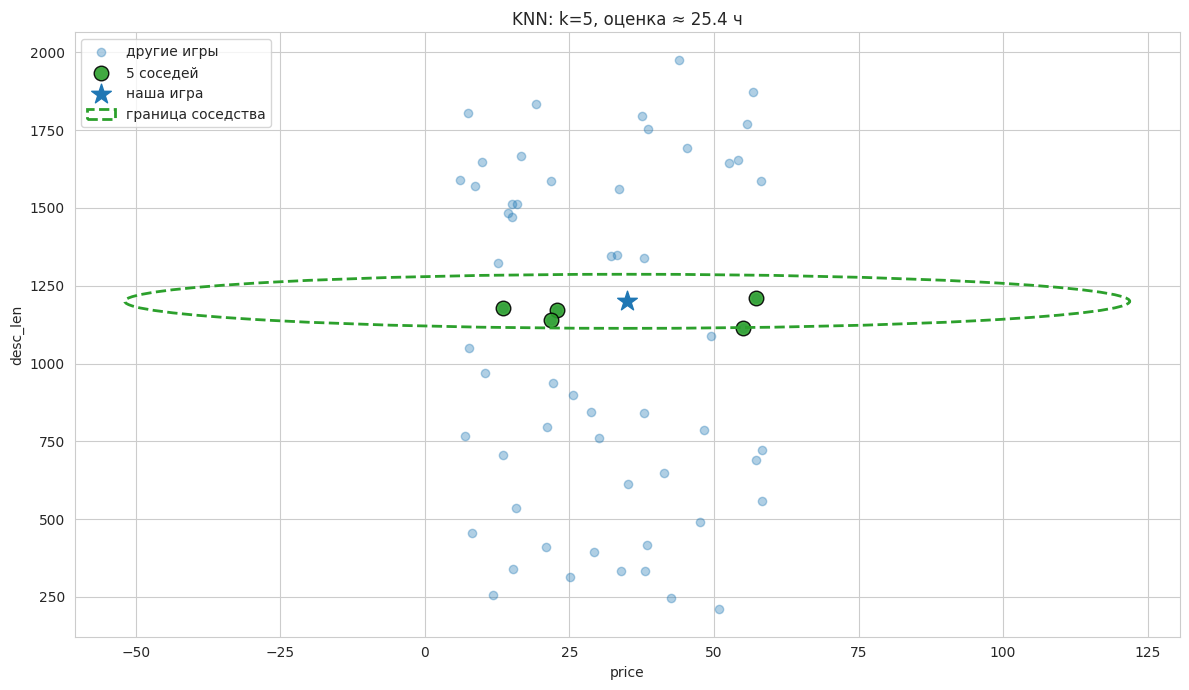

In [104]:
np.random.seed(42); n, k = 60, 5
X = np.c_[np.random.uniform(5, 60, n), np.random.uniform(200, 2000, n)]
y = 0.6*X[:,0] + 0.002*X[:,1] + np.random.normal(0, 3, n)
q = np.array([[35, 1200]])

nn = NearestNeighbors(n_neighbors=k).fit(X)
dist, idx = nn.kneighbors(q, return_distance=True)
idx = idx.ravel(); R = dist.ravel()[-1]; est = y[idx].mean()

plt.figure(figsize=(12, 7))
plt.scatter(X[:,0], X[:,1], alpha=0.35, label='другие игры')
plt.scatter(X[idx,0], X[idx,1], c='tab:green', s=110, alpha=0.9, edgecolors='k', label=f'{k} соседей')
plt.scatter(*q.T, c='tab:blue', s=220, marker='*', label='наша игра')

circle = plt.Circle((q[0,0], q[0,1]), R, fill=False, ls='--', lw=2, color='tab:green', label='граница соседства')
plt.gca().add_patch(circle)

plt.title(f'KNN: k={k}, оценка ≈ {est:.1f} ч')
plt.xlabel('price')
plt.ylabel('desc_len')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Добавим новую метрику - взвешенная оценка:

Мы посчитали байесовский взвешенный рейтинг, чтобы не завышать оценку игр с малым числом голосов

$$weighted-rating = \frac{n}{n+m} \cdot r + \frac{m}{n+m} \cdot C,$$


где

r — текущий средний rating игры,

n — ratings_count (сколько голосов у игры),

C — средняя оценка по всему очищенному датасету,

m — медианное число голосов по датасету (порог «доверия»).

https://www.algolia.com/doc/guides/managing-results/must-do/custom-ranking/how-to/bayesian-average

**Смысл**

* Если голосов мало, рейтинг тянется к общему среднему, тем самым мы не даём новичкам с несколькими оценками выскакивать в топ

* Так мы стабилизируем сравнение игр при разном количестве оценок

In [105]:
C = df['rating'].mean()
m = df['ratings_count'].median()

df['weighted_rating'] = (
    (df['ratings_count'] / (df['ratings_count'] + m)) * df['rating'] +
    (m / (df['ratings_count'] + m)) * C
).clip(0, 5)

print(f"C = {C}, m = {m}")
df[['rating','ratings_count','weighted_rating']]

C = 2.8104340636626706, m = 25.0


,rating,ratings_count,weighted_rating
0,4.58,6005.0,4.572663
1,4.49,4940.0,4.481543
2,4.09,3376.0,4.080594
3,4.48,4038.0,4.469727
4,3.52,2658.0,3.513388
...,...,...,...
2414,3.74,27.0,3.293093
2415,3.39,23.0,3.088143
2416,3.32,19.0,3.030474
2417,2.14,7.0,2.663777


Сохроним этот столбец в наш очищенный датасет

In [106]:
out_path = "dataset_final_cleaned_group_knn_with_weighted.csv"
df_with_weighted = df.copy()
df_with_weighted.to_csv(out_path, index=False)

df_with_weighted[['rating','ratings_count','weighted_rating']]

,rating,ratings_count,weighted_rating
0,4.58,6005.0,4.572663
1,4.49,4940.0,4.481543
2,4.09,3376.0,4.080594
3,4.48,4038.0,4.469727
4,3.52,2658.0,3.513388
...,...,...,...
2414,3.74,27.0,3.293093
2415,3.39,23.0,3.088143
2416,3.32,19.0,3.030474
2417,2.14,7.0,2.663777


## Обработка дубликатов

После работы с пропусками необходимо определить дубликаты.

In [107]:
full_duplicates = df.duplicated().sum()
print(f"Полных дубликатов строк: {full_duplicates}")

name_duplicates = df['name'].duplicated().sum()
print(f"Дубликатов по названию игры: {name_duplicates}")

if name_duplicates > 0:
    duplicate_names = df[df['name'].duplicated(keep=False)]['name'].unique()
    for name in duplicate_names:
        duplicates = df[df['name'] == name]
        print(f"\nНазвание: {name}")
        print(f"  Количество дубликатов: {len(duplicates)}")
        print(f"  Годы выпуска: {duplicates['release_year'].unique()}")

Полных дубликатов строк: 0
Дубликатов по названию игры: 1

Название: RefleX
  Количество дубликатов: 2
  Годы выпуска: [2014.]


Посмотрим наш дубликат:

In [108]:
df[df['name'] == 'RefleX']

,unnamed: 0,name,name_clean,released,release_year,rating,rating_top,ratings_count,added,playtime,...,currency,initial_price,final_price,discount_percent,final_formatted,packages_count,release_month,release_dow,main_genre,weighted_rating
2181,21899.0,RefleX,reflex,2014-03-27,2014.0,1.77,1.0,13.0,430.0,2.0,...,USD,799.0,799.0,0.0,$7.99,1.0,3.0,3.0,Casual,2.454496
2182,21900.0,RefleX,reflex,2014-03-27,2014.0,1.77,1.0,13.0,430.0,2.0,...,USD,99.0,99.0,0.0,$0.99,2.0,3.0,3.0,Casual,2.454496


Оказывается, что существет две игры с похожим названием: RefleX и Reflex. Вероятно, поэтому они оказались дубликатами. Мы проверили параметры игры RefleX на сайте Steam и обнаружили, что первый имеет достоверную цену, в отличае от второго. В результате этого мы оставляем первую строку, а вторую удаляем.

Кажется, что вторая строчка могла соответствовать Reflex, но у них разный год выпуска игры, поэтому мы удаляем игру.

In [109]:
df = df.drop(2182)

## Обработка выбросов

После того, как мы сделали наш датасет удобным для работы с ним, проверим его на наличае выбросов.

Анализировать выбросы мы будем только у ключевых параметров, с которыми будем дальше работать: рейтинг, взвешенный рейтинг и показатели популярности (кол-во отзывов, оценок и рекомендаций). В первую очередь пострим распределение и boxplot для каждой из величины.

In [110]:
from scipy import stats

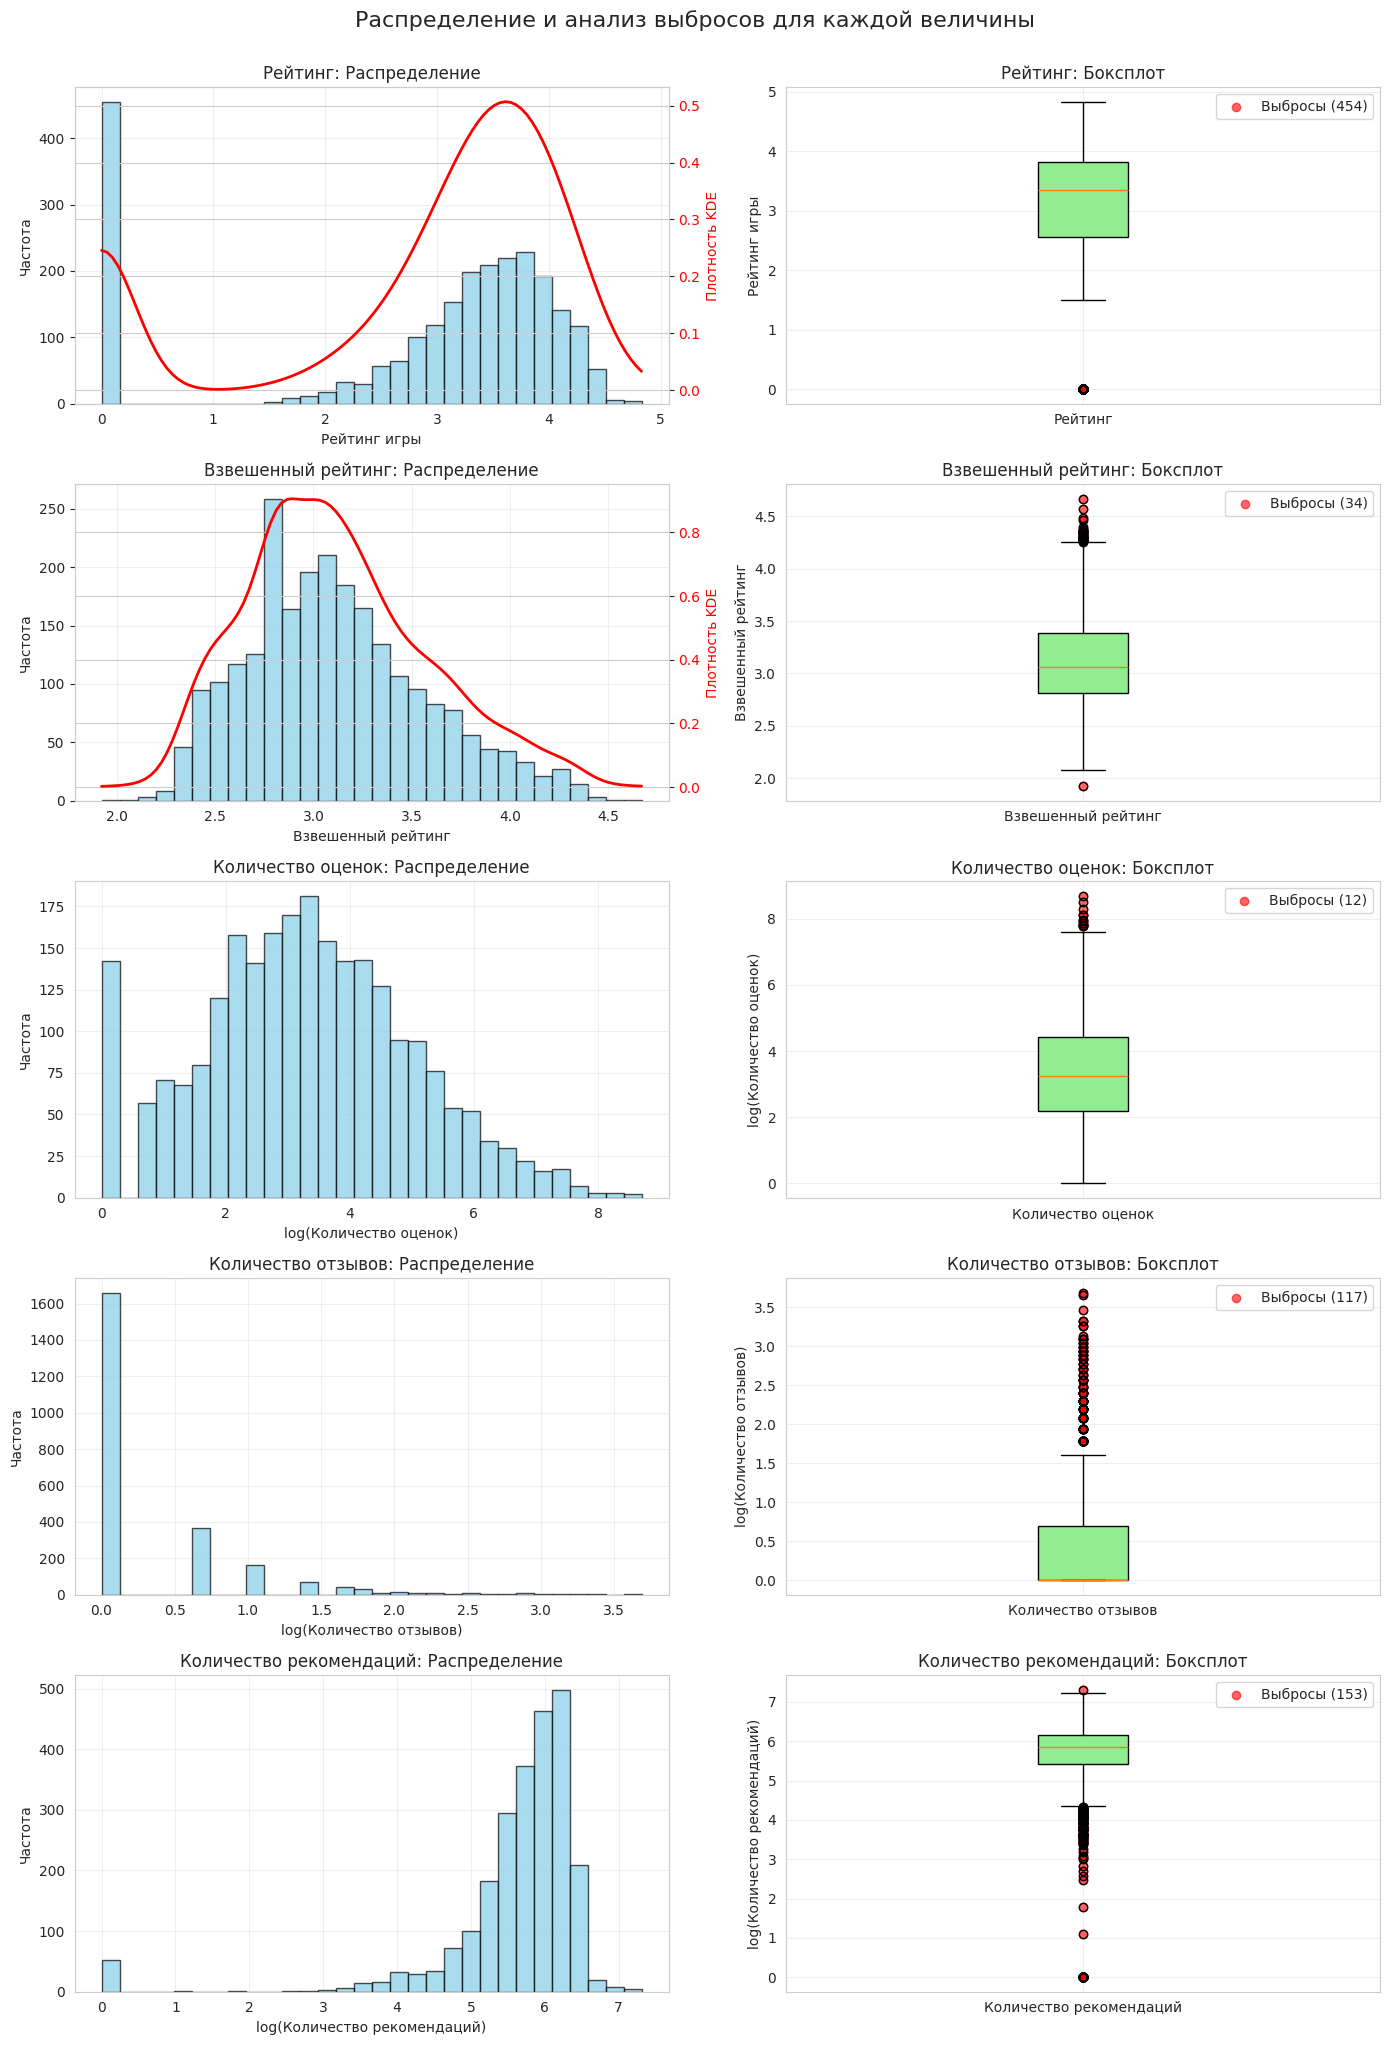

In [111]:
sns.set_style('whitegrid')

variables = {
    'Рейтинг': ['rating', 'Рейтинг игры'],
    'Взвешенный рейтинг': ['weighted_rating', 'Взвешенный рейтинг'],
    'Количество оценок': ['ratings_count', 'Количество оценок'],
    'Количество отзывов': ['reviews_count', 'Количество отзывов'],
    'Количество рекомендаций': ['suggestions_count', 'Количество рекомендаций']
}

fig, axes = plt.subplots(len(variables), 2, figsize=(14, 4*len(variables)))

for idx, (title, (var_name, var_label)) in enumerate(variables.items()):
    ax_hist = axes[idx, 0]
    if var_name in ['ratings_count', 'reviews_count', 'suggestions_count']:
        data_to_plot = np.log1p(df[var_name])
        ax_hist.hist(data_to_plot, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax_hist.set_xlabel(f'log({var_label})')
    else:
        ax_hist.hist(df[var_name], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax_hist.set_xlabel(var_label)

    if var_name in ['rating', 'weighted_rating']:
        kde = stats.gaussian_kde(df[var_name])
        x_range = np.linspace(df[var_name].min(), df[var_name].max(), 100)
        ax_hist_kde = ax_hist.twinx()
        ax_hist_kde.plot(x_range, kde(x_range), color='red', linewidth=2)
        ax_hist_kde.set_ylabel('Плотность KDE', color='red')
        ax_hist_kde.tick_params(axis='y', labelcolor='red')

    ax_hist.set_ylabel('Частота')
    ax_hist.set_title(f'{title}: Распределение')
    ax_hist.grid(True, alpha=0.3)

    ax_box = axes[idx, 1]
    if var_name in ['ratings_count', 'reviews_count', 'suggestions_count']:
        data_to_plot = np.log1p(df[var_name])
        bp = ax_box.boxplot(data_to_plot, vert=True, patch_artist=True,
                           boxprops=dict(facecolor='lightgreen'))
        ax_box.set_ylabel(f'log({var_label})')
    else:
        bp = ax_box.boxplot(df[var_name], vert=True, patch_artist=True,
                           boxprops=dict(facecolor='lightgreen'))
        ax_box.set_ylabel(var_label)

    outliers = bp['fliers'][0].get_ydata()
    if len(outliers) > 0:
        ax_box.scatter([1]*len(outliers), outliers, color='red', alpha=0.6,
                      label=f'Выбросы ({len(outliers)})')
        ax_box.legend()

    ax_box.set_title(f'{title}: Боксплот')
    ax_box.set_xticks([1])
    ax_box.set_xticklabels([title])
    ax_box.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Распределение и анализ выбросов для каждой величины', y=1.02, fontsize=16)
plt.show()

По первым двум графикам мы видим, что распределение взвешенного рейтинга похоже на нормальное, а значит, добовление этого столбца делает оценку более объективной. На первом же графике мы видим два пика: справа и слева. Это так же получается из-за того, что есть с игры с очень маленьким рейтингом.

In [112]:
def calculate_iqr_stats(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    non_outliers = data[~data.index.isin(outliers.index)]

    return {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers': outliers,
        'non_outliers': non_outliers,
        'outlier_count': len(outliers),
        'outlier_percentage': len(outliers) / len(data) * 100
    }

def calculate_iqr_stats_log(data, column):
    data[f'{column}_1'] = np.log1p(data[column])
    #print(data)
    Q1 = data[f'{column}_1'].quantile(0.25)
    Q3 = data[f'{column}_1'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[f'{column}_1'] < lower_bound) | (data[f'{column}_1'] > upper_bound)]
    non_outliers = data[~data.index.isin(outliers.index)]

    return {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers': outliers,
        'non_outliers': non_outliers,
        'outlier_count': len(outliers),
        'outlier_percentage': len(outliers) / len(data) * 100
    }

df_processed = df.copy()
stats_before = {}

for idx, (title, (var_name, var_label)) in enumerate(variables.items()):
    print(f"\n{title} ({var_name}):")

    stats_before[var_name] = calculate_iqr_stats(df, var_name)

    print(f"  IQR: {stats_before[var_name]['IQR']:.4f}")
    print(f"  Границы: [{stats_before[var_name]['lower_bound']:.4f}, {stats_before[var_name]['upper_bound']:.4f}]")
    print(f"  Выбросов: {stats_before[var_name]['outlier_count']} ({stats_before[var_name]['outlier_percentage']:.1f}%)")

    if True:
    #if var_name in ['ratings_count','reviews_count','suggestions_count']:
      stats_before[var_name] = calculate_iqr_stats_log(df, var_name)

      print(' ')
      print(f"  Для логорифмированного распределения:")
      print(f"    IQR: {stats_before[var_name]['IQR']:.4f}")
      print(f"    Границы: [{stats_before[var_name]['lower_bound']:.4f}, {stats_before[var_name]['upper_bound']:.4f}]")
      print(f"    Выбросов: {stats_before[var_name]['outlier_count']} ({stats_before[var_name]['outlier_percentage']:.1f}%)")



Рейтинг (rating):
  IQR: 1.2500
  Границы: [0.6850, 5.6850]
  Выбросов: 454 (18.8%)
 
  Для логорифмированного распределения:
    IQR: 0.3009
    Границы: [0.8184, 2.0221]
    Выбросов: 454 (18.8%)

Взвешенный рейтинг (weighted_rating):
  IQR: 0.5794
  Границы: [1.9413, 4.2590]
  Выбросов: 34 (1.4%)
 
  Для логорифмированного распределения:
    IQR: 0.1416
    Границы: [1.1254, 1.6916]
    Выбросов: 5 (0.2%)

Количество оценок (ratings_count):
  IQR: 74.7500
  Границы: [-104.1250, 194.8750]
  Выбросов: 302 (12.5%)
 
  Для логорифмированного распределения:
    IQR: 2.2306
    Границы: [-1.1487, 7.7737]
    Выбросов: 12 (0.5%)

Количество отзывов (reviews_count):
  IQR: 1.0000
  Границы: [-1.5000, 2.5000]
  Выбросов: 230 (9.5%)
 
  Для логорифмированного распределения:
    IQR: 0.6931
    Границы: [-1.0397, 1.7329]
    Выбросов: 117 (4.8%)

Количество рекомендаций (suggestions_count):
  IQR: 240.7500
  Границы: [-134.8750, 828.1250]
  Выбросов: 22 (0.9%)
 
  Для логорифмированного распр

Мы будем считать статистически важными выбросы, где их процент составляет более 5. Пройдемся по каждому признаку с выбросами:

* В рейтинге достаточно много выбросов, но в дальнейшем мы не будем использовать рейтинг, поскольку от него мы перешли к взвешенному рейтингу, в котором не значительное кол-во выбросов. Исходя из этого, с данными выбросами ничего делать не надо

* В показателях популярности (ratingы_count, suggestions_count, reviews_count) выбросов достаточно много. Однако, при логорифмировании этих же параметров наблюдается также много выбросов. Это заставляет задумать о том, что действиетельно ли они выбросы, поскольку маленькое кол-во отзывов не является аномальным событием. Исходя из этого, мы решили, что в показателях популярности нет выбросов, однако в дальнейшем мы будем иметь в виду, что в данных есть как и очень большие, так и очень маленькие значения.

В результате мы понимаем, что выбросов как таковых в нашем датасете нет.

## Обработка значений в столбцах

В данных видно, что неправильно обработаны значений цен при отказывания от валюты. Исправим это, разделив initial_price, final_price на 100.

In [113]:
df['initial_price'] = df['initial_price']/100
df['final_price'] = df['final_price']/100

In [114]:
df

,unnamed: 0,name,name_clean,released,release_year,rating,rating_top,ratings_count,added,playtime,...,final_formatted,packages_count,release_month,release_dow,main_genre,weighted_rating,weighted_rating_1,ratings_count_1,reviews_count_1,suggestions_count_1
0,2.0,Portal 2,portal 2,2011-04-18,2011.0,4.58,5.0,6005.0,20739.0,11.0,...,$9.99,3.0,4.0,0.0,Shooter,4.572663,1.717873,8.700514,3.688879,6.342121
1,5.0,Portal,portal,2007-10-09,2007.0,4.49,5.0,4940.0,17684.0,4.0,...,$9.99,3.0,10.0,1.0,Action,4.481543,1.701387,8.505323,3.465736,5.720312
2,6.0,Left 4 Dead 2,left 4 dead 2,2009-11-17,2009.0,4.09,4.0,3376.0,17442.0,9.0,...,$9.99,2.0,11.0,1.0,Action,4.080594,1.625428,8.124743,2.708050,6.410175
3,10.0,Half-Life 2,half-life 2,2004-11-16,2004.0,4.48,5.0,4038.0,15988.0,7.0,...,$9.99,3.0,11.0,1.0,Action,4.469727,1.699229,8.303752,2.890372,6.347389
4,14.0,Destiny 2,destiny 2,2017-09-06,2017.0,3.52,4.0,2658.0,14558.0,6.0,...,$9.99,5.0,9.0,2.0,Action,3.513388,1.507048,7.885705,3.091042,7.126891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,23912.0,Noitu Love 2: Devolution,noitu love 2: devolution,2012-04-23,2012.0,3.74,4.0,27.0,366.0,2.0,...,$4.99,1.0,4.0,0.0,Indie,3.293093,1.457008,3.332205,0.000000,5.393628
2415,23914.0,8-Bit Armies,8-bit armies,2016-04-21,2016.0,3.39,4.0,23.0,318.0,3.0,...,$14.99,1.0,4.0,3.0,Strategy,3.088143,1.408091,3.178054,0.000000,6.269096
2416,23929.0,eversion,eversion,2010-06-07,2010.0,3.32,4.0,19.0,255.0,3.0,...,$4.99,1.0,6.0,0.0,Indie,3.030474,1.393884,2.995732,0.000000,4.934474
2417,23936.0,Trip to Vinelands,trip to vinelands,2016-10-21,2016.0,2.14,1.0,7.0,242.0,2.0,...,$0.49,3.0,10.0,4.0,Indie,2.663777,1.298494,2.079442,0.000000,4.477337


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2418 entries, 0 to 2418
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   unnamed: 0           2418 non-null   float64       
 1   name                 2418 non-null   object        
 2   name_clean           2418 non-null   object        
 3   released             2418 non-null   datetime64[ns]
 4   release_year         2418 non-null   float64       
 5   rating               2418 non-null   float64       
 6   rating_top           2418 non-null   float64       
 7   ratings_count        2418 non-null   float64       
 8   added                2418 non-null   float64       
 9   playtime             2418 non-null   float64       
 10  metacritic           2418 non-null   float64       
 11  reviews_count        2418 non-null   float64       
 12  suggestions_count    2418 non-null   float64       
 13  rating_5             2418 non-null   f

Для начала удалим столбцы, которые не имеют отношения к решению нашей бизнес-задачи. К ним относятся:

* reddit_url - не дает новой информации про игру
* reddit_name - не дает новой информации про игру
* reddit_description - не дает новой информации про игру
* unnamed: 0 - технический столбец
* name_clean - технический столбец
* final_formatted - объединение стобцов currency и final_price
* primary_genre - является подмножеством столбца main_genre

In [116]:
del df['reddit_description'], df['reddit_name'], df['reddit_url'], df['unnamed: 0'], df['name_clean'], df['final_formatted'], df['primary_genre']

В завершении поработаем с metacritic и metacritic_score. Эти столбцы отвечают за оценки критиков на платформе Metacritic.

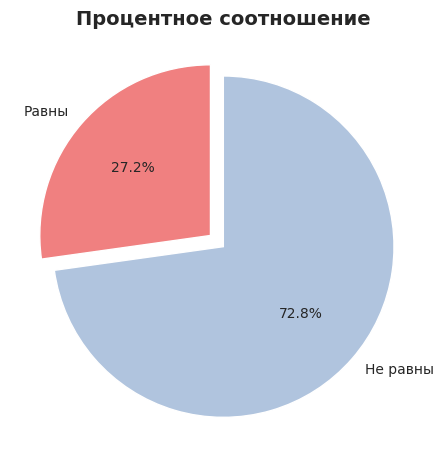

In [117]:
equal_count = (df['metacritic'] == df['metacritic_score']).sum()
not_equal_count = len(df) - equal_count

categories = ['Равны', 'Не равны']
counts = [equal_count, not_equal_count]
colors = ['lightcoral', 'lightsteelblue']

plt.pie(counts, labels=categories, autopct='%1.1f%%', colors=colors,
        startangle=90, explode=(0.1, 0))
plt.title('Процентное соотношение', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Значения в большиснтве столбцов различаются, что связано с тем, что они отображены на двух разных платформах RAWG и Steam Store, но на разную дату. Для того, чтобы сохранить оценки, но чтобы не гадать на какую из дат более актуальные оценки, мы возьмем среднее арифмитическое между ними.

In [118]:
df['metacritic'] = round((df['metacritic']+ df['metacritic_score'])/2,2)

In [119]:
del df['metacritic_score']

In [120]:
df.to_csv('dataset_final_cleaned.csv', index=False)